# Irma ensemble forecasts analysis 

### What aspects of the INITIAL TIME differences are correlated with 
### LANDFALL TIME outcome measures (strength, track)?

Jump to [Results](#results)

In [1]:
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

data are on [weather server](https://weather.rsmas.miami.edu/repository/entry/show?entryid=88c07b73-cf8d-4426-9254-16c8e75c2811), click and grab OpenDAP link for your initialization time (several are there) 

In [2]:
# on weather server, i extracted two OpenDAP URLs with copy-paste
# These two are for GEFS_Global_1p0deg_Ensemble_20170904_1800.grib2 <-- this is fcst initialization time

# Full ensemble (21 members): 
URLens = 'https://weather.rsmas.miami.edu/repository/opendap/synth%3A88c07b73-cf8d-4426-9254-16c8e75c2811%3AL0dFRlNfR2xvYmFsXzFwMGRlZ19FbnNlbWJsZV8yMDE3MDkwNF8xODAwLmdyaWIy/entry.das'
ds = xr.open_dataset(URLens)
# Derived (mean and stdev and stuff)
URLder = 'https://weather.rsmas.miami.edu/repository/opendap/synth%3A88c07b73-cf8d-4426-9254-16c8e75c2811%3AL0dFRlNfR2xvYmFsXzFwMGRlZ19FbnNlbWJsZV9kZXJpdmVkXzIwMTcwOTA0XzE4MDAuZ3JpYjI%3D/entry.das'
ds_der = xr.open_dataset(URLder)

# Create outcome measures of ensemble differences at landfall time
## to correlate with *initial time* fields 

In [3]:
# Region of interest: Near Florida, landfall time

roi = ds.sel(lon=slice(360-90,360-60), lat=slice(35,20)) 
landfall = roi.sel(time2='2017-09-11 00:00:00')

# First landfall-time outcome measure: strength
### Use min SLP as strength measure

min, max:  946.84875 974.057421875  hPa


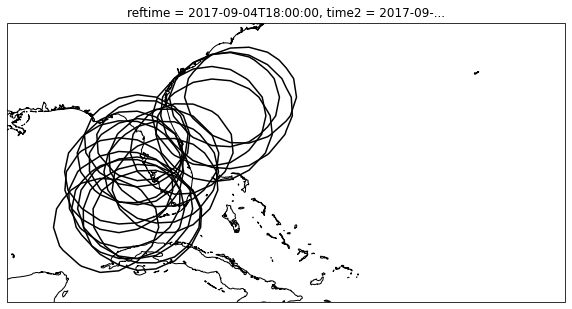

In [4]:
# Quick plot of SLP 990hPa contours, and find minimum values
SLPmins = []

# on a map 
projection = ccrs.PlateCarree()
f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=[10,8])

for iens in range(21):
    SLP = landfall.Pressure_reduced_to_MSL_msl_ens[iens]
    contours = SLP.plot.contour(ax=ax,colors='k', vmin=99000,vmax=99000,levels=1)
    #print('min value: ', SLP.min().values/100.)
    SLPmins.append(SLP.min().values/100.) 

ax.coastlines();
    
print('min, max: ', min(SLPmins), max(SLPmins), ' hPa')

In [23]:
minima = roi.Pressure_reduced_to_MSL_msl_ens.argmin(dim=['lat','lon'])

In [24]:
minima

{'lat': <xarray.DataArray 'Pressure_reduced_to_MSL_msl_ens' (time2: 65, ens: 21)>
 array([[15, 15, 15, ..., 15, 15, 15],
        [15, 15, 15, ..., 15, 15, 15],
        [15, 15, 15, ..., 15, 15, 15],
        ...,
        [15,  9, 12, ...,  2, 15,  0],
        [15,  7, 12, ...,  1, 15,  0],
        [15,  6, 11, ...,  1, 15,  0]])
 Coordinates:
     reftime  datetime64[ns] 2017-09-04T18:00:00
   * time2    (time2) datetime64[ns] 2017-09-04T18:00:00 ... 2017-09-20T18:00:00
   * ens      (ens) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20,
 'lon': <xarray.DataArray 'Pressure_reduced_to_MSL_msl_ens' (time2: 65, ens: 21)>
 array([[30, 30, 30, ..., 30, 30, 30],
        [ 0, 30,  0, ...,  0, 30,  0],
        [29, 29, 29, ..., 29, 29, 29],
        ...,
        [ 2, 30,  8, ..., 22,  0, 26],
        [ 2, 30,  8, ..., 23,  6, 28],
        [ 1, 30,  8, ..., 24,  0, 30]])
 Coordinates:
     reftime  datetime64[ns] 2017-09-04T18:00:00
   * time2    (time2) datetime64[ns] 2017-09-04T18:00

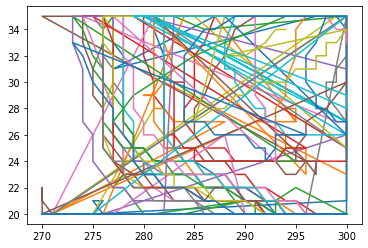

In [17]:
plt.plot(roi.lon[ centers['lon'] ], roi.lat[centers['lat']])

In [5]:
SLP.argmin?

Signature:
SLP.argmin(
    dim: 'Hashable | Sequence[Hashable]' = None,
    axis: 'int' = None,
    keep_attrs: 'bool' = None,
    skipna: 'bool' = None,
) -> 'DataArray | dict[Hashable, DataArray]'
Docstring:
Index or indices of the minimum of the DataArray over one or more dimensions.

If a sequence is passed to 'dim', then result returned as dict of DataArrays,
which can be passed directly to isel(). If a single str is passed to 'dim' then
returns a DataArray with dtype int.

If there are multiple minima, the indices of the first one found will be
returned.

Parameters
----------
dim : hashable, sequence of hashable or ..., optional
    The dimensions over which to find the minimum. By default, finds minimum over
    all dimensions - for now returning an int for backward compatibility, but
    this is deprecated, in future will return a dict with indices for all
    dimensions; to return a dict with all dimensions now, pass '...'.
axis : int, optional
    Axis over which to apply `a

# Second landfall-time outcome measure: track
### Measure it as a dipole mode in EOF(lat,lon)PC(ens) decomposition
Assuming some mode will be a dipole: second if not first... 

In [5]:
# EOFs of the landfall-time SLP field. Have to rename "ens" to "time" dimension
from eofs.xarray import Eof


solver = Eof( landfall.Pressure_reduced_to_MSL_msl_ens.rename({'ens':'time'}) )
pc = solver.pcs(npcs=1).rename({'time':'ens'})  #, pcscaling=1)
eof = solver.eofs(neofs=1)

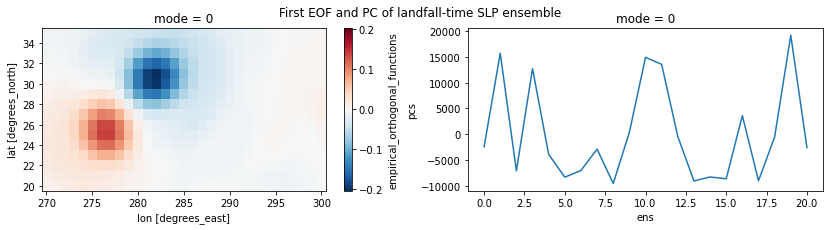

In [6]:
# Depict  it:
fig, axes = plt.subplots(ncols=2, figsize=(14,3))
fig.suptitle('First EOF and PC of landfall-time SLP ensemble')
eof.plot(ax=axes[0])
pc.plot(ax=axes[1])  #; plt.xlabel('ens. member')

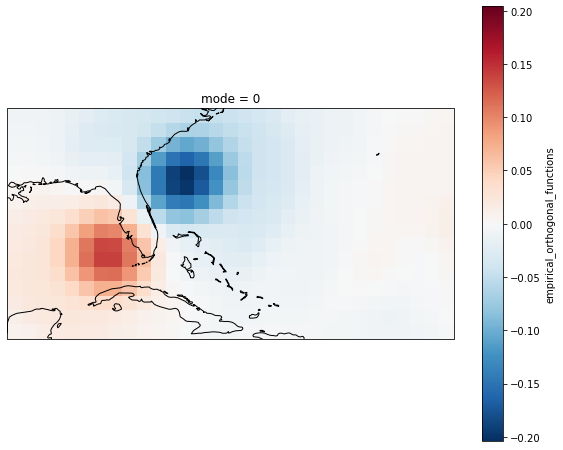

In [7]:
# Put the EOF on a proper map 
projection = ccrs.PlateCarree()
f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=[10,8])
eof.plot(ax=ax);
ax.coastlines();

In [8]:
# Correlation of SLP AT ALL TIMES IN BIG REGION with LANDFALL TIME outcome measures. 

bigroi = ds.sel(lon=slice(360-100,360-30), lat=slice(50,10)) 

# TRACK:
# use the measure of NE-SW displacement: EOF1 Mode amplitude. Rename "time" to "ens" (Eofs package demanded it)
pccor = xr.corr(pc[:,0], bigroi['Pressure_reduced_to_MSL_msl_ens'], dim="ens")

# STRENGTH: 
# use with strength measure: SLPmins. Have to make it a xarray DataArray with dimesnion called "ens" 
xSLPmins = xr.DataArray(SLPmins, dims="ens")
SLPcor =xr.corr(xSLPmins, bigroi['Pressure_reduced_to_MSL_msl_ens'], dim="ens")

<a id='results'></a>
### Result: Maps at INITIAL time, of SLP correlations with LANDFALL-time track, SLPmin

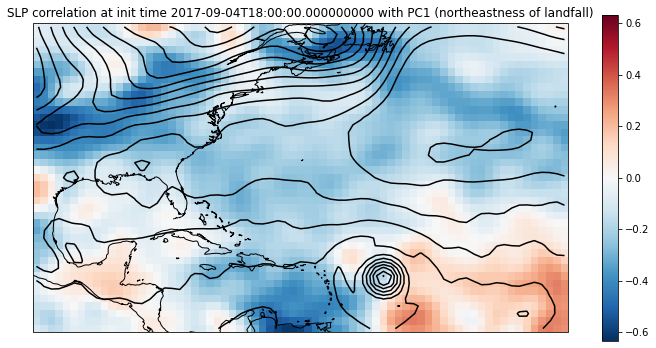

In [9]:
# Necessary for a map 
projection = ccrs.PlateCarree()
f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=[12,6])

# Show PCcor field
pccor[0].plot(ax=ax)

# Overplot ensemble mean SLP so we can interpret correlations 
MSLP = ds_der.Pressure_reduced_to_MSL_msl_unweightedMean.sel(lon=slice(360-100,360-30), lat=slice(50,10))
MSLP[0].plot.contour(colors='k',vmin=95000,vmax=102000,levels=30)
ax.coastlines();

ax.set_title('SLP correlation at init time '+str(pccor.time2[0].values)+\
             ' with PC1 (northeastness of landfall)');

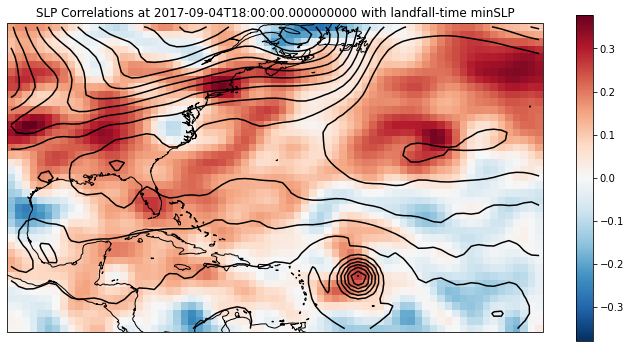

In [10]:
# Necessary for a map 
projection = ccrs.PlateCarree()
f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=[12,6])

# Show SLPcor field
SLPcor[0].plot(ax=ax, cmap='RdBu_r')

# Overplot ensemble mean SLP so we can interpret correlations 
MSLP = ds_der.Pressure_reduced_to_MSL_msl_unweightedMean.sel(lon=slice(360-100,360-30), lat=slice(50,10))
MSLP[0].plot.contour(colors='k',vmin=95000,vmax=102000,levels=30)
ax.coastlines();

ax.set_title('SLP correlation at init time '+str(pccor.time2[0].values)+\
             ' with PC1 (northeastness of landfall)')

ax.set_title('SLP Correlations at '+str(SLPcor.time2[0].values)+' with landfall-time minSLP');

# How about Z500, sort of a steering level for vorticity features

In [11]:
# bigroi.Geopotential_height_isobaric_ens

In [ ]:
# TRACK:
# use the measure of NE-SW displacement: EOF1 Mode amplitude. Rename "time" to "ens" (Eofs package demanded it)
pccorZ = xr.corr(pc[:,0], bigroi['Geopotential_height_isobaric_ens'].sel(isobaric2=50000), dim="ens")

# STRENGTH: 
# use with strength measure: SLPmins. Have to make it a xarray DataArray with dimesnion called "ens" 
xSLPmins = xr.DataArray(SLPmins, dims="ens")
SLPcorZ =xr.corr(xSLPmins, bigroi['Geopotential_height_isobaric_ens'].sel(isobaric2=50000), dim="ens")

In [ ]:
projection = ccrs.PlateCarree()
f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=[12,6])

pccorZ[0].plot(ax=ax)

# Overplot ensemble mean SLP so we can interpret correlations 
Z500 = ds_der.Geopotential_height_isobaric_unweightedMean.sel(lon=slice(360-100,360-30), lat=slice(50,10), isobaric2=50000)
Z500[0].plot.contour(colors='k',levels=23)
ax.coastlines();

ax.set_title('Z500 correlation at init time '+str(pccor.time2[0].values)+\
             ' with PC1 (northeastness of landfall)');

In [ ]:
projection = ccrs.PlateCarree()
f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=[12,6])

SLPcorZ[0].plot(ax=ax)

# Overplot ensemble mean SLP so we can interpret correlations 
Z500 = ds_der.Geopotential_height_isobaric_unweightedMean.sel(lon=slice(360-100,360-30), lat=slice(50,10), isobaric2=50000)
Z500[0].plot.contour(colors='k',levels=23)
ax.coastlines();

ax.set_title('Z500 correlation at init time '+str(pccor.time2[0].values)+\
             ' with minSLP at landfall time');

# Let's get quantitative: make the above correlation map into a REGRESSION map
## Units: (UNITS OF OUTCOME) per (UNIT OF PREDICTOR)

**regression** of minSLP on Z is this statistical model for ensemble deviations:

### $SLP_{min}' = reg(SLP_{min},Z_{500}) * Z_{500}'$

Formula is: **think units: it could be no other!**

### $reg(SLP_{min},Z_{500}) = cor(SLP_{min},Z_{500}) \times \sigma_{SLP_{min}} / \sigma_{Z_{500}}$


In [ ]:
# use Pascal units for SLPmins
SLPregZ = SLPcorZ * 100*np.std(SLPmins) / ds_der.Geopotential_height_isobaric_stdDev.sel(lon=slice(360-100,360-30), lat=slice(50,10), isobaric2=50000)

In [ ]:
projection = ccrs.PlateCarree()
f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=[12,6])

SLPregZ[0].plot(ax=ax)

# Overplot ensemble mean SLP so we can interpret correlations 
Z500 = ds_der.Geopotential_height_isobaric_unweightedMean.sel(lon=slice(360-100,360-30), lat=slice(50,10), isobaric2=50000)
Z500[0].plot.contour(colors='k',levels=23)
ax.coastlines();

ax.set_title('Pascals of landfall SLPmin per local meter of Z500 at '+str(pccor.time2[0].values));

In [ ]:
# quick old looks at ensemble global SLP values from this dataset
# and dataset metadata dumps 

In [ ]:
# let's take the 30th time level so the values differ substantially
ds.Pressure_reduced_to_MSL_msl_ens[30]

In [ ]:
# spaghetti plot at lead time 20 steps (5 days)
for iens in range(21):
    contours = ds.Pressure_reduced_to_MSL_msl_ens[20][iens].plot.contour(cmap='RdBu',vmin=95000,vmax=102000,levels=8)
    
plt.colorbar(contours)

In [ ]:
# Mean and standard deviation
ds_der.Pressure_reduced_to_MSL_msl_stdDev[15].plot.contourf(levels=25, cmap='gray')
ds_der.Pressure_reduced_to_MSL_msl_unweightedMean[15].plot.\
    contour(cmap='RdBu',vmin=95000,vmax=102000,levels=8)

In [ ]:
ds_der = xr.open_dataset(URLder)
ds_der

In [ ]:
ds